## Q1. データベース作成
ダウンロードしたcsvファイル内のデータをSQLiteのデータベースに格納せよ．テーブル名はdepartmentのように，csvファイル名から拡張子を取り除いたものにせよ．ただし，order_products__train.csvとorder_products__prior.csvのデータについては，order_productsというテーブルを作成し，そこにデータを格納せよ．カラム情報はdata/instacartディレクトリのdata-recipe.mdファイルに記した内容に従うこと．

なお，必要であれば，data/instacartディレクトリのinit_sqlite.sqlファイルを利用してもよい．

In [1]:

import sqlite3
import pandas as pd
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
#DB作成
dbpath = 'instacart.db'
connection = sqlite3.connect(dbpath)
# cursor = connection.cursor()

connection.close()

In [3]:
#Q1
#テーブル作成
connection = sqlite3.connect(dbpath)
cur = connection.cursor()


cur.execute('''CREATE TABLE departments(
                                                    department_id INTEGER PRIMARY KEY, 
                                                    department VARCHAR(128))''')

cur.execute('''CREATE TABLE aisles(
                                                    aisle_id INTEGER PRIMARY KEY, 
                                                    aisle TEXT
                                                    )''')

cur.execute('''CREATE TABLE products(
                                                    product_id INTEGER PRIMARY KEY, 
                                                    product_name TEXT, 
                                                    aisle_id INTEGER, 
                                                    department_id INTEGER,
                                                    foreign key (aisle_id) references aisles(aisle_id),
                                                    foreign key (department_id) references departments(department_id)
                                                    )''')

cur.execute('''CREATE TABLE orders(
                                                    order_id INTEGER PRIMARY KEY, 
                                                    user_id INTEGER, 
                                                    eval_set TEXT,
                                                    order_number INTEGER,
                                                    order_dow INTEGER,
                                                    order_hour_of_day TEXT,
                                                    days_since_prior INTEGER
                                                    )''')

cur.execute('''CREATE TABLE order_products (
                                                    order_id int  NOT NULL,
                                                    product_id int  NOT NULL,
                                                    add_to_cart_order int,
                                                    reordered int,
                                                    foreign key (order_id) references orders(order_id),
                                                    foreign key (product_id) references products(product_id)
                                                    )''')

connection.commit()
connection.close()


OperationalError: table departments already exists

In [4]:
#csv読み込み ターミナルで．
# .mode csv
# .import instacart_2017_05_01/aisles.csv aisles
# .import instacart_2017_05_01/departments.csv departments
# .import instacart_2017_05_01/products.csv products
# .import instacart_2017_05_01/orders.csv orders
# .import instacart_2017_05_01/order_products__prior.csv order_products
# .import instacart_2017_05_01/order_products__train.csv order_products

## Q2. pandasデータフレームへの読み込み
pandasライブラリのread_sql関数を用いると，SQLite上にあるデータベースにSQLを発行し，その結果をpandas.DataFrameデータフレームに読み出すことができる．下記コードは，SQLite上にあるinstacartデータベースのdepartmentテーブルの内容をデータフレームに読み込む例である．

productsテーブル，aislesテーブル，departmentsテーブル，ordersテーブル，order_productsテーブルのレコード数を調べるSQL文を発行し，各テーブルのレコード数を表示せよ．

In [10]:
db = sqlite3.connect(dbpath)
sql = "SELECT * FROM aisles;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）

# 最初の5件を表示
df.head()
# print(type(df))

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
db = sqlite3.connect(dbpath)
sql = "SELECT count(*) FROM aisles;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head()

,count(*)
0,134


In [11]:
db = sqlite3.connect(dbpath)
sql = "SELECT count(*) FROM departments;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head()

,count(*)
0,21


In [12]:
db = sqlite3.connect(dbpath)
sql = "SELECT count(*) FROM departments;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head()

,count(*)
0,21


In [13]:
db = sqlite3.connect(dbpath)
sql = "SELECT count(*) FROM products;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head()

,count(*)
0,49688


In [14]:
db = sqlite3.connect(dbpath)
sql = "SELECT count(*) FROM orders;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head()

,count(*)
0,3421083


## Q3. マスターデータ作成（テーブル結合 & 集約演算）
商品部門別および商品棚別に商品数を求めるSQL文を発行し，その結果をデータフレーム形式で表示せよ．なお，表示するデータフレームは下記の形式とせよ（ALLは特定のdepartmentにある全aisleを意味する）．また表示する結果は，商品数の降順でソートしたものとせよ．

In [35]:
db = sqlite3.connect(dbpath)
sql = '''
            SELECT department, 
                            aisle, 
                            COUNT(*) as iterm_count
            FROM departments as d, 
                        aisles as a, 
                        products as p
            WHERE p.department_id = d.department_id
            AND p.aisle_id = a.aisle_id
            GROUP BY department, aisle
            
            UNION
            
            SELECT department, 'ALL' as aisle, COUNT(*) as iterm_count
            FROM departments as d,   products as p
            WHERE p.department_id = d.department_id
            GROUP BY department, aisle
            ORDER BY iterm_count DESC
        
        
        '''
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(100)

,department,aisle,iterm_count
0,personal care,ALL,6563
1,snacks,ALL,6264
2,pantry,ALL,5371
3,beverages,ALL,4365
4,frozen,ALL,4007
5,dairy eggs,ALL,3449
6,household,ALL,3085
7,canned goods,ALL,2092
8,dry goods pasta,ALL,1858
9,produce,ALL,1684


## Q4. 注文行動に関する基礎情報（集約演算2）
ユーザID毎に注文回数（order_frequency）および注文の平均間隔（avg_order_interval）を把握したい．注文回数が10回以上99以下のユーザに関して，ユーザID毎の注文回数と注文平均間隔を求めるSQL文を発行し，注文平均間隔の上位10件（昇順）のユーザ情報のみ表示せよ．結果はデータフレーム形式で表示せよ．なお，ある注文が初回注文だった場合，前回の注文からの経過日数間隔はゼロと考えよ．

In [6]:
db = sqlite3.connect(dbpath)
# sql = '''
#            SELECT user_id, order_num, AVG(days_since_prior)
#            FROM (SELECT user_id, 
#                                        count(*) as order_num , 
#                                        AVG(days_since_prior) as av_days_since_prior
#                         FROM order)
#            WHERE 
        
        
#         '''
sql = '''
            SELECT user_id,
                            order_num,
                            av_days_since_prior
            FROM (SELECT user_id, 
                                        count(*) as order_num , 
                                        AVG(days_since_prior) as av_days_since_prior
                        FROM orders
                        GROUP BY user_id
                        ORDER BY av_days_since_prior)
            WHERE order_num BETWEEN 10 AND 99
        '''
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(10)

,user_id,order_num,av_days_since_prior
0,88589,27,0.518519
1,58157,48,0.604167
2,31834,11,0.818182
3,204214,23,0.826087
4,190812,16,0.875000
5,309,26,0.961538
6,15963,10,1.000000
7,68345,10,1.000000
8,175931,42,1.000000
9,192717,10,1.000000


## Q5. 注文タイミング（ヒートマップによる可視化）
注文があった曜日および時間帯別（例: 土曜日の23時）の注文総数を集計するSQL文を発行し，その結果をヒートマップ形式で表示せよ．

In [8]:
import seaborn as sns
%matplotlib inline

In [9]:
db = sqlite3.connect(dbpath)
sql = '''
         SELECT order_dow, order_hour_of_day, count(*) as order_num
         FROM orders
         GROUP BY order_dow, order_hour_of_day
         '''

df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(50)

,order_dow,order_hour_of_day,order_num
0,0,00,3936
1,0,01,2398
2,0,02,1409
3,0,03,963
4,0,04,813
5,0,05,1168
6,0,06,3329
7,0,07,12410
8,0,08,28108
9,0,09,40798


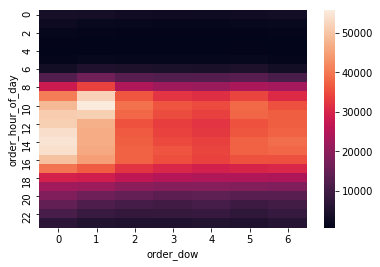

In [13]:
#特定の列の型を変換 sns.heatmapが数値型しか受け取らないため
df_align_col = df.astype({'order_hour_of_day': 'int64'})
# print(df_align_col.dtypes)

#x軸を曜日別　y軸を時間帯別に整形する　クロス集計
df_order_timinig = df_align_col.pivot_table(index = 'order_hour_of_day', columns = 'order_dow', values = 'order_num', aggfunc=np.sum)

sns.heatmap(df_order_timinig)

## Q6. 注文間隔（棒グラフによる可視化）
前回の注文からの経過日数別に注文数を集計するSQL文を発行し，その結果を棒グラフで示せ．

In [14]:
db = sqlite3.connect(dbpath)
sql = '''
         SELECT days_since_prior, count(*) as order_num
         FROM orders
         WHERE days_since_prior != ''
         GROUP BY days_since_prior
         ORDER BY days_since_prior
         '''

df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(5)


,days_since_prior,order_num
0,0,67755
1,1,145247
2,2,193206
3,3,217005
4,4,221696


    days_since_prior  order_num
0                  0      67755
1                  1     145247
2                  2     193206
3                  3     217005
4                  4     221696
5                  5     214503
6                  6     240013
7                  7     320608
8                  8     181717
9                  9     118188
10                10      95186
11                11      80970
12                12      76146
13                13      83214
14                14     100230
15                15      66579
16                16      46941
17                17      39245
18                18      35881
19                19      34384
20                20      38527
21                21      45470
22                22      32012
23                23      23885
24                24      20712
25                25      19234
26                26      19016
27                27      22013
28                28      26777
29                29      19191
30      

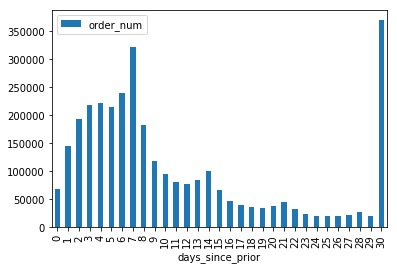

In [15]:
# print(df.dtypes)
# df_order_interval = df.pivot(index = 'order_num', columns = 'days_since_prior', values = 'order_num')
print(df)
df.plot.bar('days_since_prior')

## Q7. ユーザの利用頻度（副問い合わせ）
顧客の注文回数を集計することで注文回数別の顧客数を求めるSQL文を発行し，その結果を棒グラフで表示せよ．

In [28]:
db = sqlite3.connect(dbpath)
sql = '''
        SELECT order_num, count(user_id) as user_num
        FROM(SELECT MAX(order_number) as order_num, 
                                user_id
                    FROM orders
                    GROUP BY user_id)
        GROUP BY order_num
        ORDER BY order_num 
         '''


df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(10)


,order_num,user_num
0,4,23986
1,5,19590
2,6,16165
3,7,13850
4,8,11700
5,9,10190
6,10,9032
7,11,7815
8,12,6952
9,13,6236


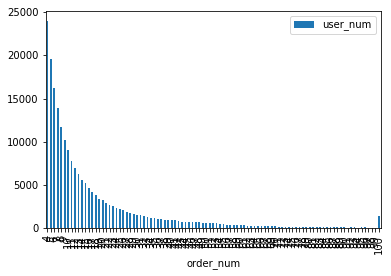

In [29]:
df.plot.bar('order_num')

## Q8. 再注文率（SQL上での算術演算）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果を表示せよ．なお，結果は再注文率でソートしたものを表示せよ．

In [35]:
db = sqlite3.connect(dbpath)
sql = '''
        SELECT departments.department_id, 
                department,
                COUNT(*) AS total_order,
                CAST(SUM(reordered) AS float) / COUNT(*) AS re_order_rate
        FROM   orders, 
                order_products, 
                products,
                departments
        WHERE orders.order_id = order_products.order_id
        AND order_products.product_id = products.product_id
        AND departments.department_id = products.department_id
        GROUP BY products.department_id
        ORDER BY re_order_rate DESC
         '''

df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(30)

,department_id,department,total_order,re_order_rate
0,16,dairy eggs,5631067,0.670161
1,7,beverages,2804175,0.653651
2,4,produce,9888378,0.650521
3,3,bakery,1225181,0.628381
4,20,deli,1095540,0.608130
5,8,pets,102221,0.602557
6,18,babies,438743,0.577680
7,10,bulk,35932,0.577090
8,19,snacks,3006412,0.574464
9,5,alcohol,159294,0.571221


## Q9. 商品棚にみる注文回数の分布（Window関数で四分位数を求める）
"pantry"売り場の商品棚別に注文回数の四分位数を求めるSQL文を発行し，その結果をデータフレームに格納し表示せよ．

In [80]:
db = sqlite3.connect(dbpath)
sql = '''
        SELECT aisle, count(*) as order_num 
        FROM aisles, products, orders, order_products, departments
        WHERE orders.order_id = order_products.order_id
        AND order_products.product_id = products.product_id
        AND products.aisle_id = aisles.aisle_id
        AND products.department_id = departments.department_id
        AND departments.department = "pantry"
        GROUP BY aisles.aisle_id
        ORDER BY order_num
         '''


df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(150)

#問題文の求めることがわからなかった

,aisle,order_num
0,baking supplies decor,24786
1,marinades meat preparation,65415
2,honeys syrups nectars,69790
3,salad dressing toppings,104050
4,doughs gelatins bake mixes,110847
5,preserved dips spreads,113879
6,pickled goods olives,117521
7,spices seasonings,221371
8,condiments,231792
9,oils vinegars,256086


## Q10. 商品棚別の注文数および再注文率（リッチな可視化）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果をデータフレームに格納せよ．また，集計結果をもとに，X軸に注文総数（対数スケール），Y軸に再注文率とする散布図を描け．

In [36]:
db = sqlite3.connect(dbpath)
sql = '''
        SELECT departments.department, 
                        count(*) as order_num, 
                        CAST(SUM(reordered) AS float) / count(*) as re_order_rate
        FROM orders, 
                    order_products, 
                    products, 
                    departments
        WHERE orders.order_id = order_products.order_id
        AND order_products.product_id = products.product_id
        AND products.department_id = departments.department_id
        GROUP BY departments.department_id
        ORDER BY order_num
        
         '''

df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
df.head(30)

,department,order_num,re_order_rate
0,bulk,35932,0.577090
1,other,38086,0.407052
2,missing,77396,0.394323
3,pets,102221,0.602557
4,alcohol,159294,0.571221
5,international,281155,0.369682
6,babies,438743,0.577680
7,personal care,468693,0.321863
8,breakfast,739069,0.561351
9,meat seafood,739238,0.568625


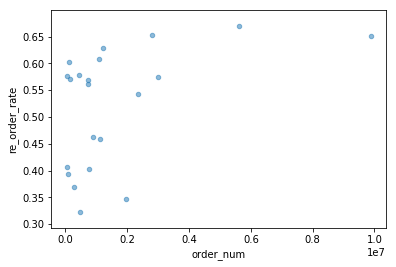

In [37]:
df.plot.scatter(x='order_num', y='re_order_rate', alpha=0.5)
#対数スケールのやり方